In [1]:
import math
import torch
import torch.nn as nn
import tqdm
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp, quad
from numpy.linalg import inv

class TimeGridError(Exception):
    pass

class UpdateERROR(Exception):
    pass
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Helper Functions
def get_time_grid(t_0,T,tau_size):
    if t_0 == T:
        return np.array([T])
    part_no = np.divide(T-t_0, tau_size)
    tt = np.divide(T-t_0, part_no)
    grid = np.arange(t_0, T+0.00001, tt)
    return grid


def round_nearest(num: float, to: float) -> float:
    return round(num / to) * to

def round_down(num: float, to: float) -> float:
    nearest = round_nearest(num, to)
    if math.isclose(num, nearest): return num
    return nearest if nearest < num else nearest - to

In [3]:
class LQR:
    def __init__(self, H, M, C, D, R, t_0 = 0, T = 1, n=100):
      self.H = H
      self.M = M
      self.C = C
      self.D = D
      self.R = R
      self.t_0 = t_0
      self.T = T
      #helper properties for faster computation
      self.number_of_time_steps = n
      self.tau = np.divide(T - t_0, self.number_of_time_steps)
      self.D_inv = inv(self.D)

    #Helper function
    def change_no_of_time_steps(self,n):
        self.number_of_time_steps = n
        self.tau = np.divide(self.T-self.t_0,n)

    #Helper function
    def update_t_0_and_T(self, t_0,T, n=None):
        self.t_0 = t_0
        self.T = T
        if n is None:
            n = self.number_of_time_steps
        self.change_no_of_time_steps(n)

    def ricatti_ode(self, t, Q, H, M, C, D):
      # using Q' = -S'(T-t)
      Q = Q.reshape(2, 2)
      dq = 2* H.T @ Q - Q @ M @ np.linalg.inv(D) @ M @ Q + C
      return dq.flatten()

    def solve_ricatti_ode(self, time_grid):
      if len(time_grid) == 1:
        return [self.R]
      S_T = self.R.flatten() # initial y_0 must be 1-d
      res = solve_ivp(self.ricatti_ode, (time_grid[0], time_grid[-1]), S_T, t_eval=time_grid, args=(self.H, self.M, self.C, self.D))
      return res.y.T.reshape(-1, 2, 2)[::-1]

    def control_problem_value(self, time_tensor, space_tensor, sigma):
      v = []
      for t, x in zip(time_tensor, space_tensor):
        time_grid = get_time_grid(t,self.T, self.tau)
        S = self.solve_ricatti_ode(time_grid) #time_tensor[t:] if time tensor if confirmed that it is ordered
        integral = 0
        for s_t in S:
          integral += np.trace(sigma @ sigma.transpose() * s_t) * self.tau# double check with sigma different sizes

        v_values = x @ S[0] @ torch.t(x) + integral
        v.append(v_values.flatten()[0])
      return torch.tensor(v)

    def markov_control(self, time_tensor, space_tensor):
      a = np.zeros(shape=(1, 2))
      for t, x in zip(time_tensor, space_tensor):
        time_grid = get_time_grid(t,self.T, self.tau)
        S = self.solve_ricatti_ode(time_grid)
        a = np.vstack((a,(-self.D_inv @ self.M.transpose() @ S[0] @ x.numpy().transpose()).transpose()))
      return torch.tensor(a[1:])


dim = 2
H = np.identity(dim)
M = np.identity(dim)
C = 0.1 * np.identity(dim)
D = 0.1 * np.identity(dim)
R = np.identity(dim)
sigma = np.array([0.05,0.05])  # 2 rows  d dimensional columns for R-d dim wiener
T = 1.0
t_0 = 0.5

# Example Function Calls
batch_size = 1

time_grid = get_time_grid(t_0,T, 0.01)
time_tensor = torch.tensor(np.random.uniform(low=0.5, high=0.5, size=batch_size)).unsqueeze(1)
space_tensor = torch.tensor(np.random.uniform(low=(3, 2), high=(3, 2), size=(batch_size,1, 2)))


lqr = LQR(H, M, C, D, R, t_0, T)

# Example Call to helper functions
# lqr.change_no_of_time_steps(10)
# lqr.update_t_0_and_T(0.1,1,25)

#Example call to Class functions
S = lqr.solve_ricatti_ode(time_grid)
v= lqr.control_problem_value(time_tensor, space_tensor, sigma)
a= lqr.markov_control(time_tensor, space_tensor)




Sample Problem with t_0 = 0.5, T=1, x=(3,2)
Value for problem: tensor([3.9367], dtype=torch.float64)
Markov control for problem: tensor([[-9.0792, -6.0528]], dtype=torch.float64)
Plot of S:


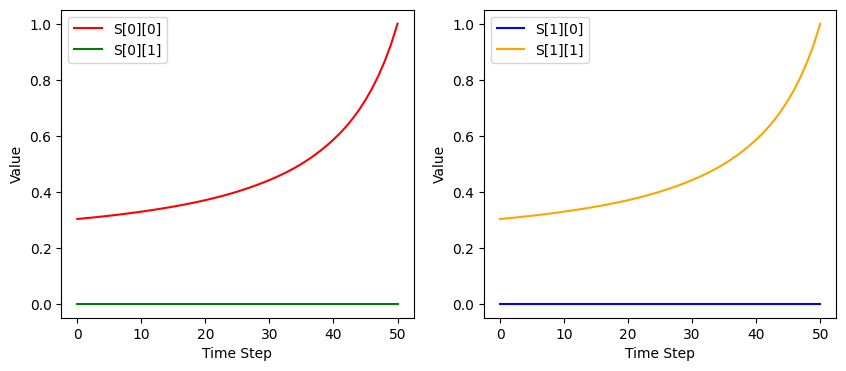

In [4]:
print('Sample Problem with t_0 = 0.5, T=1, x=(3,2)')
print('Value for problem: {}'.format(v))
print('Markov control for problem: {}'.format(a))

print('Plot of S:')
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot([s[0][0] for s in S], label='S[0][0]', color='red')
ax[0].plot([s[0][1] for s in S], label='S[0][1]', color='green')
ax[0].set_xlabel('Time Step')
ax[0].set_ylabel('Value')
ax[0].legend()

ax[1].plot([s[1][0] for s in S], label='S[1][0]', color='blue')
ax[1].plot([s[1][1] for s in S], label='S[1][1]', color='orange')
ax[1].set_xlabel('Time Step')
ax[1].set_ylabel('Value')
ax[1].legend()

plt.show()


Deep Neural networks to obtain value function and optimal control

In [5]:
class DGM_Layer(nn.Module):
    def __init__(self, dim_x, dim_S, activation='Tanh'):
        super(DGM_Layer, self).__init__()

        if activation == 'ReLU':
            self.activation = nn.ReLU()
        elif activation == 'Tanh':
            self.activation = nn.Tanh()
        elif activation == 'Sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'LogSigmoid':
            self.activation = nn.LogSigmoid()
        else:
            raise ValueError("Unknown activation function {}".format(activation))


        self.gate_Z = self.layer(dim_x+dim_S, dim_S)
        self.gate_G = self.layer(dim_x+dim_S, dim_S)
        self.gate_R = self.layer(dim_x+dim_S, dim_S)
        self.gate_H = self.layer(dim_x+dim_S, dim_S)

    def layer(self, nIn, nOut):
        l = nn.Sequential(nn.Linear(nIn, nOut), self.activation)
        return l

    def forward(self, x, S):
        x_S = torch.cat([x,S],1)
        Z = self.gate_Z(x_S)
        G = self.gate_G(x_S)
        R = self.gate_R(x_S)

        input_gate_H = torch.cat([x, S*R],1)
        H = self.gate_H(input_gate_H)

        output = ((1-G))*H + Z*S
        return output


class Net_DGM(nn.Module):

    def __init__(self, dim_x, dim_S, activation='Tanh'):
        super(Net_DGM, self).__init__()

        self.dim = dim_x
        if activation == 'ReLU':
            self.activation = nn.ReLU()
        elif activation == 'Tanh':
            self.activation = nn.Tanh()
        elif activation == 'Sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'LogSigmoid':
            self.activation = nn.LogSigmoid()
        else:
            raise ValueError("Unknown activation function {}".format(activation))

        self.input_layer = nn.Sequential(nn.Linear(dim_x+1, dim_S), self.activation).to(torch.float64)

        self.DGM1 = DGM_Layer(dim_x=dim_x+1, dim_S=dim_S, activation=activation).to(torch.float64)
        self.DGM2 = DGM_Layer(dim_x=dim_x+1, dim_S=dim_S, activation=activation).to(torch.float64)
        self.DGM3 = DGM_Layer(dim_x=dim_x+1, dim_S=dim_S, activation=activation).to(torch.float64)

        self.output_layer = nn.Linear(dim_S, 1).to(torch.float64)

    def forward(self,t,x):
        tx = torch.cat([t,x], 1)
        S1 = self.input_layer(tx)
        S2 = self.DGM1(tx,S1)
        S3 = self.DGM2(tx,S2)
        S4 = self.DGM3(tx,S3)
        output = self.output_layer(S4)
        return output

In [6]:
class FFN(nn.Module):

    def __init__(self, sizes, activation=nn.ReLU, output_activation=nn.Identity, batch_norm=False):
        super().__init__()

        layers = [nn.BatchNorm1d(sizes[0]),] if batch_norm else []
        for j in range(len(sizes)-1):
            layers.append(nn.Linear(sizes[j], sizes[j+1]).to(torch.float64))
            if batch_norm:
                layers.append(nn.BatchNorm1d(sizes[j+1], affine=True))
            if j<(len(sizes)-2):
                layers.append(activation())
            else:
                layers.append(output_activation())

        self.net = nn.Sequential(*layers).to(torch.float64)

    def freeze(self):
        for p in self.parameters():
            p.requires_grad=False

    def unfreeze(self):
        for p in self.parameters():
            p.requires_grad=True

    def forward(self, x):
        return self.net(x).to(torch.float64)


In [7]:
# 2.1 Setup
t_0 = 0
T = 1
batch_size = 256

time_tensor_dim = 1
space_tensor_dim = 1 * 2

dmg_hidden_layer_size = 100
ffm_hidden_layer_size = 100

loss_improvement_limit = 20
max_num_epochs = 1000

# Define the loss function
loss_function = nn.MSELoss()

lqr_2 = LQR(H, M, C, D, R, t_0, T)


In [8]:
# 2.1 Value function - Training takes roughly 8 minutes to train
# Use First part to generate the value for training data
lqr_2.update_t_0_and_T(t_0=t_0,T=T,n=100)

# Generate prediction
net_dgm = Net_DGM(dim_x=time_tensor_dim + space_tensor_dim - 1, dim_S=dmg_hidden_layer_size)

# Create the optimizer
optimizer = torch.optim.Adam(net_dgm.parameters(), lr=0.001)

losses = [0]
train = True
loss_no_improvement_counter = 0
epoch_counter = 0
print('Starting Training Epoch 0 / {}'.format(max_num_epochs))
while train:
    epoch_counter +=1
    if epoch_counter%50 == 0:
        print('Epoch {} / {}'.format(epoch_counter,max_num_epochs))
    t_tensor = torch.tensor(np.random.uniform(low=0, high=T, size=batch_size)).unsqueeze(1)
    x_tensor = torch.tensor(np.random.uniform(low=(-3, -3), high=(3, 3), size=(batch_size,1, 2)))
    x_reshaped = x_tensor.reshape(-1, 2)

    y = lqr_2.control_problem_value(t_tensor, x_tensor, sigma).unsqueeze(1)
    y_pred = net_dgm.forward(t_tensor, x_reshaped).to(torch.float64)

    # Compute loss
    loss = loss_function(y_pred, y)
    losses.append(loss.item())
    net_dgm.zero_grad()
    loss.backward()
    optimizer.step()

    if losses[-1] >  losses[-2]:
        loss_no_improvement_counter +=1
        if loss_no_improvement_counter >= loss_improvement_limit:
            train = False
    else:
        loss_no_improvement_counter = 0

    if epoch_counter > max_num_epochs:
        train = False


Starting Training Epoch 0 / 1000
Epoch 50 / 1000
Epoch 100 / 1000
Epoch 150 / 1000
Epoch 200 / 1000
Epoch 250 / 1000
Epoch 300 / 1000
Epoch 350 / 1000
Epoch 400 / 1000
Epoch 450 / 1000
Epoch 500 / 1000
Epoch 550 / 1000
Epoch 600 / 1000
Epoch 650 / 1000
Epoch 700 / 1000
Epoch 750 / 1000
Epoch 800 / 1000
Epoch 850 / 1000
Epoch 900 / 1000
Epoch 950 / 1000
Epoch 1000 / 1000


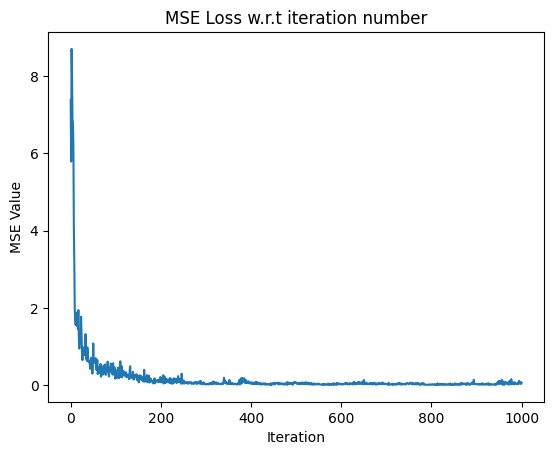

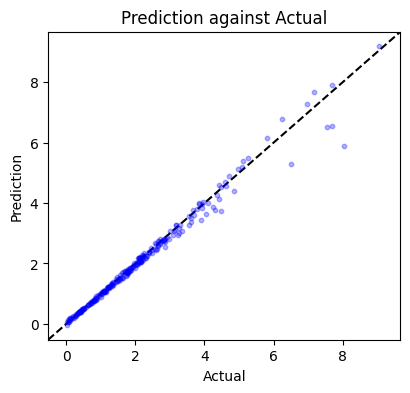

Value Neural Network Training Loss MSE 0.06115036062198154
Validation Loss MSE 0.13439704461097218
Specific Value pred 3.6371157853573783, theoretical value 3.9366972120660604


In [9]:
training_loss_net_dgm = loss
# Plot losses over iteration
plt.plot(losses[1:])
plt.xlabel('Iteration')
plt.ylabel('MSE Value')
plt.title('MSE Loss w.r.t iteration number')
plt.show()

# Plot actual vs prediction
fig = plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.scatter(y.detach().numpy(), y_pred.detach().numpy(), c='blue', s=10, alpha=0.3)
x1, x2 = plt.xlim()
y1, y2 = plt.ylim()
lim = min(x1, y1), min(x2, y2)
plt.xlim(*lim)
plt.ylim(*lim)
plt.plot(lim, lim, 'k--', zorder=-1)
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.title('Prediction against Actual')
plt.show()

print('Value Neural Network Training Loss MSE {}'.format(training_loss_net_dgm))

# Validation testing
t_tensor_val = torch.tensor(np.random.uniform(low=0, high=T, size=batch_size)).unsqueeze(1)
x_tensor_val = torch.tensor(np.random.uniform(low=(-3, -3), high=(3, 3), size=(batch_size,1, 2)))
x_reshaped_val = x_tensor_val.reshape(-1, 2)

y = lqr_2.control_problem_value(t_tensor_val, x_tensor_val, sigma).unsqueeze(1)
y_pred = net_dgm.forward(t_tensor_val, x_reshaped_val).to(torch.float64)
# Compute loss
loss = loss_function(y_pred, y)
print('Validation Loss MSE {}'.format(loss))

# Specific value testing
time_tensor = torch.tensor(np.random.uniform(low=0.5, high=0.5, size=1)).unsqueeze(1)
space_tensor = torch.tensor(np.random.uniform(low=(3, 2), high=(3, 2), size=(1,1, 2)))
x_reshaped = space_tensor.reshape(-1, 2)
input_tensor = torch.cat((time_tensor, x_reshaped), dim=1)
y = lqr_2.control_problem_value(time_tensor, space_tensor, sigma).unsqueeze(1)
y_pred = net_dgm.forward(time_tensor, x_reshaped).to(torch.float64)
print('Specific Value pred {}, theoretical value {}'.format(y_pred.item(),y.item()))


Exercise 2.2

In [15]:
#2.2
sizes = [time_tensor_dim + space_tensor_dim, 100, 100, 2]
net_ffn_control = FFN(sizes = sizes)
optimizer = torch.optim.Adam(net_ffn_control.parameters(), lr=0.001)

losses = [0]
train = True
loss_no_improvement_counter = 0
epoch_counter = 0
print('Starting Training Epoch 0 / {}'.format(max_num_epochs))
while train:
    epoch_counter +=1
    if epoch_counter%50 == 0:
        print('Epoch {} / {}'.format(epoch_counter,max_num_epochs))
    t_tensor = torch.tensor(np.random.uniform(low=0, high=T, size=batch_size)).unsqueeze(1)
    x_tensor = torch.tensor(np.random.uniform(low=(-3, -3), high=(3, 3), size=(batch_size,1, 2)))
    x_reshaped = x_tensor.reshape(-1, 2)
    input_tensor = torch.cat((t_tensor, x_reshaped), dim=1)

    y = lqr_2.markov_control(t_tensor, x_tensor)
    y_pred = net_ffn_control.forward(input_tensor).to(torch.float64)

    # Compute loss
    loss = loss_function(y_pred, y)
    losses.append(loss.item())
    net_ffn_control.zero_grad()
    loss.backward()
    optimizer.step()

    if losses[-1] >  losses[-2]:
        loss_no_improvement_counter +=1
        if loss_no_improvement_counter >= loss_improvement_limit:
            train = False
    else:
        loss_no_improvement_counter = 0

    if epoch_counter > max_num_epochs:
        train = False


Starting Training Epoch 0 / 1000
Epoch 50 / 1000
Epoch 100 / 1000
Epoch 150 / 1000
Epoch 200 / 1000
Epoch 250 / 1000
Epoch 300 / 1000
Epoch 350 / 1000
Epoch 400 / 1000
Epoch 450 / 1000
Epoch 500 / 1000
Epoch 550 / 1000
Epoch 600 / 1000
Epoch 650 / 1000
Epoch 700 / 1000
Epoch 750 / 1000
Epoch 800 / 1000
Epoch 850 / 1000
Epoch 900 / 1000
Epoch 950 / 1000
Epoch 1000 / 1000


Control Neural Network Training Loss MSE 1.8485810973179184
Validation Loss MSE 2.2387265647393684
Specific Value pred tensor([-10.3311,  -7.0056], dtype=torch.float64, grad_fn=<SelectBackward0>),
Theoretical value tensor([[-9.0792, -6.0528]], dtype=torch.float64)


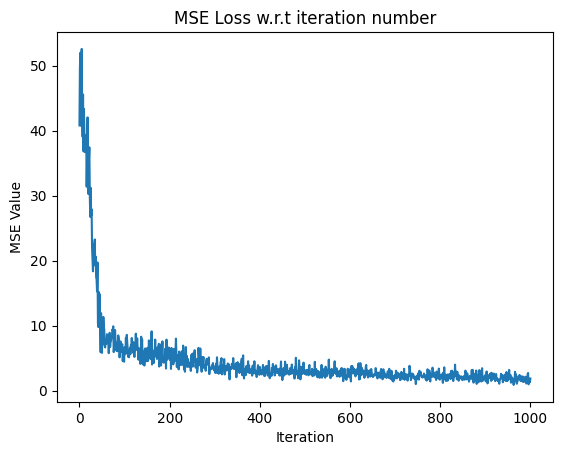

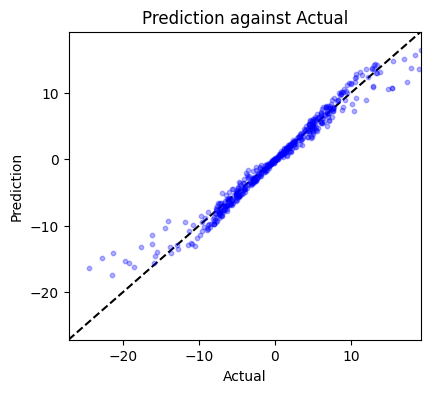

In [16]:
training_loss_net_ffm = loss

losses = losses[1:]
print('Control Neural Network Training Loss MSE {}'.format(training_loss_net_ffm))

y = lqr_2.markov_control(t_tensor_val, x_tensor_val).unsqueeze(1)
input_tensor_val = torch.cat((t_tensor_val, x_reshaped_val), dim=1)
y_pred = net_ffn_control.forward(input_tensor_val).to(torch.float64)
# Compute loss
loss = loss_function(y_pred.reshape(batch_size,2), y.reshape(batch_size,2))
print('Validation Loss MSE {}'.format(loss))


#Specific value testing
time_tensor = torch.tensor(np.random.uniform(low=0.5, high=0.5, size=1)).unsqueeze(1)
space_tensor = torch.tensor(np.random.uniform(low=(3, 2), high=(3, 2), size=(1,1, 2)))
x_reshaped = space_tensor.reshape(-1, 2)
input_tensor = torch.cat((time_tensor, x_reshaped), dim=1)
y_s = lqr_2.markov_control(time_tensor, space_tensor).unsqueeze(1)
y_pred_s = net_ffn_control.forward(input_tensor).to(torch.float64)
print('Specific Value pred {},\nTheoretical value {}'.format(y_pred_s[0],y_s[0]))


# Plot losses over iteration
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('MSE Value')
plt.title('MSE Loss w.r.t iteration number')
plt.show()

# Plot actual vs prediction
fig = plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.scatter(y.detach().numpy(), y_pred.detach().numpy(), c='blue', s=10, alpha=0.3)
x1, x2 = plt.xlim()
y1, y2 = plt.ylim()
lim = min(x1, y1), min(x2, y2)
plt.xlim(*lim)
plt.ylim(*lim)
plt.plot(lim, lim, 'k--', zorder=-1)
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.title('Prediction against Actual')
plt.show()



QUESTION 3


100%|██████████| 1000/1000 [01:43<00:00,  8.78it/s]

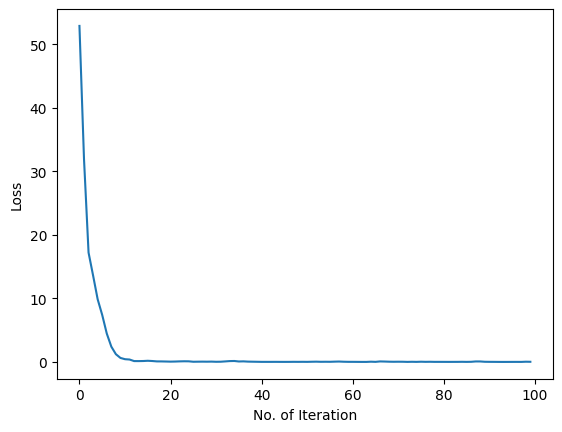

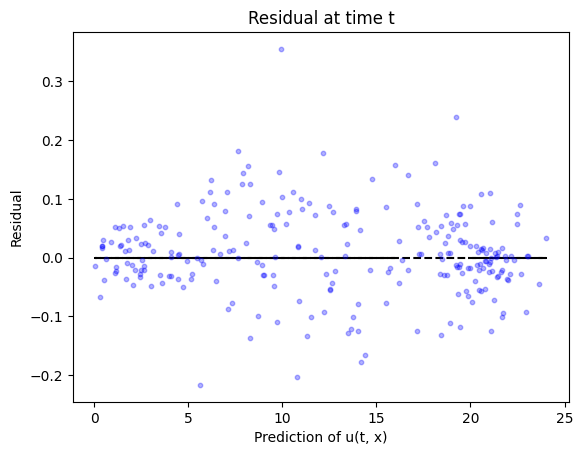

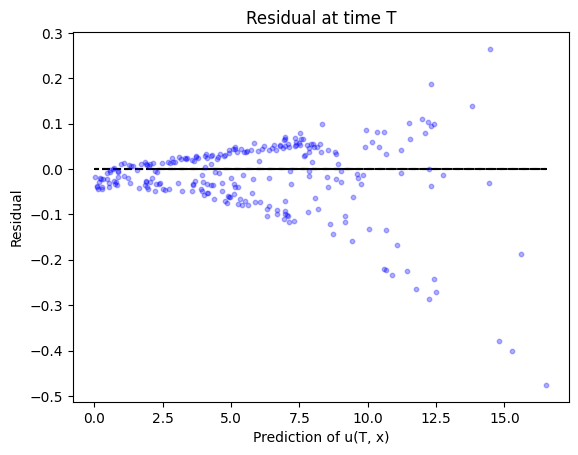

100%|██████████| 1000/1000 [01:55<00:00,  8.68it/s]


In [17]:
# Training takes about 2 minutes
lqr_3 = LQR(H, M, C, D, R, t_0=0, T=1)

def get_gradient(output, x):
    grad = torch.autograd.grad(output, x, grad_outputs=torch.ones_like(output), create_graph=True, retain_graph=True, only_inputs=True)[0]
    return grad

def get_hessian(grad, x):
    hessian = torch.zeros(x.shape[0], x.shape [1],x.shape[1])
    for d in range(x.shape[1]):
        v = grad[:,d].view(-1,1)
        grad_2 = torch.autograd.grad(v,x,grad_outputs=torch.ones_like(v), only_inputs=True, create_graph=True, retain_graph=True)[0]
        hessian[:,d] = grad_2
    return hessian.to(torch.float64)


class PDE_DGM(torch.nn.Module):
    def __init__(self, H, M, C, D, R, sigma, alpha=np.array([1.0, 1.0]).T):
        super().__init__()
        self.H = torch.tensor(H)
        self.M = torch.tensor(M)
        self.C = torch.tensor(C)
        self.D = torch.tensor(D)
        self.R = torch.tensor(R)
        self.sigma = torch.tensor(sigma).reshape(2,1)
        self.sigma_sigma_t = torch.tensor(self.sigma @ self.sigma.T)
        self.alpha = torch.tensor(alpha).reshape(2,1)
        self.M_alpha = self.M @ self.alpha
        self.a_D_a = self.alpha.T @ self.D @ self.alpha
        self.net_dgm = Net_DGM(time_tensor_dim + space_tensor_dim - 1, 100, activation='Tanh')

    def fit(self, batch_size, num_epochs_limit, plot=True):
        # Create Adam optimizer
        optimizer = torch.optim.Adam(self.net_dgm.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones = (10000,) ,gamma=0.1)
        loss_fn = torch.nn.MSELoss()

        # Train model
        pbar = tqdm.tqdm(total=num_epochs_limit)
        losses = []

        for iter in range(num_epochs_limit):
            if iter in [1,10,50,100,500, num_epochs_limit-1]:
                #for plot against monte carlo
                for case in range(len(mc_test_cases)):
                    arr = mc_test_cases[case]
                    test_t_against_monte_carlo = torch.tensor(np.array([float(lqr_3.t_0)]),requires_grad=True).unsqueeze(1)
                    x_tensor_against_monte_carlo = torch.tensor(arr,requires_grad=True).reshape(1,2)
                    training_against_monte_carlo_vals[case].append(self.net_dgm(test_t_against_monte_carlo, x_tensor_against_monte_carlo))

            t_tensor = torch.tensor(np.random.uniform(low=lqr_3.t_0, high=lqr_3.T, size=batch_size),requires_grad=True).unsqueeze(1)#lqr_3.t_0 + lqr_3.T*torch.rand(batch_size, 1, requires_grad=True)
            x_tensor = torch.tensor(np.random.uniform(low=(-3, -3), high=(3, 3), size=(batch_size, 2)),requires_grad=True)
            u_of_tx = self.net_dgm(t_tensor, x_tensor)
            grad_u_x = get_gradient(u_of_tx, x_tensor)
            grad_u_t = get_gradient(u_of_tx, t_tensor)
            hessian = get_hessian(grad_u_x, x_tensor)
            target_equation = torch.zeros_like(u_of_tx)

            trace_sigma_sigma_hessian = torch.matmul(self.sigma_sigma_t,hessian)
            trace_sigma_sigma_hessian = (0.5 * torch.vmap(torch.trace)(trace_sigma_sigma_hessian)).reshape(batch_size,1)
            H_x_grad = (grad_u_x *  torch.transpose((self.H @ x_tensor.T),0,1)).sum(axis=1).reshape(batch_size,1)
            M_alpha_grad = torch.matmul(grad_u_x,self.M_alpha)
            x_C_x = (x_tensor *  torch.transpose((self.C @ x_tensor.T),0,1)).sum(axis=1).reshape(batch_size,1)

            pde = grad_u_t + trace_sigma_sigma_hessian + H_x_grad + M_alpha_grad + x_C_x + self.a_D_a

            MSE_equation = loss_fn(pde, target_equation)

            # Compute R boundary
            t_tensor_terminal = torch.ones(batch_size, 1) * lqr_3.T
            x_tensor_terminal = torch.tensor(np.random.uniform(low=(-3, -3), high=(3, 3), size=(batch_size, 2)))
            u_of_tx_terminal = self.net_dgm(t_tensor_terminal, x_tensor_terminal)
            target_boundary = (x_tensor_terminal *  torch.transpose((self.R @ x_tensor_terminal.T),0,1)).sum(axis=1).reshape(batch_size,1)
            MSE_boundary = loss_fn(u_of_tx_terminal, target_boundary)

            # Store loss values
            loss = MSE_equation + MSE_boundary
            losses.append(loss.item())

            self.net_dgm.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

            if iter % 100 == 0:
                pbar.update(100)

        if plot:
            # Plot training loss graph
            plt.plot(losses[0::10])
            plt.xlabel('No. of Iteration')
            plt.ylabel('Loss')
            plt.show()
            # print(losses)

            # Plot loss over equation 1
            plt.scatter(u_of_tx.detach().numpy(), pde.detach().numpy(), c='blue', s=10, alpha=0.3)
            plt.plot(u_of_tx.detach().numpy(), torch.zeros_like(u_of_tx).detach().numpy(), 'k--', zorder=-1)
            plt.xlabel('Prediction of u(t, x)')
            plt.ylabel('Residual')
            plt.title('Residual at time t')
            plt.show()

            # Plot loss over equation 2
            plt.scatter(u_of_tx_terminal.detach().numpy(), (u_of_tx_terminal- target_boundary).detach().numpy(), c='blue', s=10, alpha=0.3)
            plt.plot(u_of_tx_terminal.detach().numpy(), torch.zeros_like(u_of_tx_terminal).detach().numpy(), 'k--', zorder=-1)
            plt.xlabel('Prediction of u(T, x)')
            plt.ylabel('Residual')
            plt.title('Residual at time T')
            plt.show()

    def forward(self, t_tensor, x_tensor):
        return self.net_dgm.forward(t_tensor, x_tensor).to(torch.float64)

training_against_monte_carlo_vals = {}
mc_test_cases = [np.array((3.0,2.0)),np.array((0.0,1.2)),np.array((1.8,2.2)),np.array((0.9,-2.0)),np.array((-0.5,-1.5)),np.array((3.0,3.0)),np.array((-3.0,-3.0)),np.array((1.0,1.0))]
for case in range(len(mc_test_cases)):
    training_against_monte_carlo_vals[case] = []


dgm = PDE_DGM(H, M, C, D, R, sigma)
dgm.fit(256, 1000, plot=True)

In [18]:
# testing
def test_3(H, M, C, D, R, sigma):
    batch_size = 1
    H = torch.tensor(H)
    M = torch.tensor(M)
    C = torch.tensor(C)
    D = torch.tensor(D)
    R = torch.tensor(R)
    sigma = torch.tensor(sigma).reshape(2,1)
    sigma_sigma_t = torch.tensor(sigma @ sigma.T)
    alpha = np.array([1.0, 1.0]).T
    alpha = torch.tensor(alpha).reshape(2,1)
    M_alpha = M @ alpha
    a_D_a = alpha.T @ D @ alpha
    t_tensor = torch.tensor(np.random.uniform(low=0.5, high=0.5, size=(batch_size, 1)), requires_grad=True)
    x_tensor = torch.tensor(np.random.uniform(low=(3, 2), high=(3, 2), size=(batch_size, 2)), requires_grad=True)
    u_of_tx = dgm.forward(t_tensor, x_tensor)
    grad_u_x = get_gradient(u_of_tx, x_tensor)
    grad_u_t = get_gradient(u_of_tx, t_tensor)
    hessian = get_hessian(grad_u_x, x_tensor)

    trace_sigma_sigma_hessian = torch.matmul(sigma_sigma_t,hessian)
    trace_sigma_sigma_hessian = (0.5 * torch.vmap(torch.trace)(trace_sigma_sigma_hessian)).reshape(batch_size,1)
    H_x_grad = (grad_u_x *  torch.transpose((H @ x_tensor.T),0,1)).sum(axis=1).reshape(batch_size,1)
    M_alpha_grad = torch.matmul(grad_u_x,M_alpha)
    x_C_x = (x_tensor *  torch.transpose((C @ x_tensor.T),0,1)).sum(axis=1).reshape(batch_size,1)

    pde = grad_u_t + trace_sigma_sigma_hessian + H_x_grad + M_alpha_grad + x_C_x + a_D_a

    t_tensor_terminal = torch.ones(batch_size, 1) * 1
    x_tensor_terminal = torch.tensor(np.random.uniform(low=(3, 2), high=(3, 2), size=(batch_size, 2)))
    u_of_tx_bound = dgm.forward(t_tensor_terminal, x_tensor_terminal)
    target_boundary = (x_tensor_terminal *  torch.transpose((R @ x_tensor_terminal.T),0,1)).sum(axis=1).reshape(batch_size, 1)

    print(f'Equation 1: {pde}, Target: 0')
    print(f'u(T,x): {u_of_tx_bound}, Target: {target_boundary}')

test_3(H, M, C, D, R, sigma)

Equation 1: tensor([[-0.0245]], dtype=torch.float64, grad_fn=<AddBackward0>), Target: 0
u(T,x): tensor([[13.0318]], dtype=torch.float64, grad_fn=<AddmmBackward0>), Target: tensor([[13.]], dtype=torch.float64)
